# Text Classification with an RNN in 

1. Setup of Libraries.
2. Download/ Access Raw Data.
3. Create a Text Encoder. This step allows to convert sentences of words into vector representations using tokenization. Some text-preprocessing is required in this step also.
4. Optimize the text dataset. Some cool features from TF re used to improve memory and optimization.
5. Create the Model. Some times this step will be directly from the TF 2.0 API, or simply using a Sequential model from Keras. A key aspect is necesary to notice. SInce we are working with vector representations of words, it is necesary to build embeddings. Embeeddings are tipically dense encodings of words. Ideally, similar words have similar encodings. 
6. Compile the model. Depending on the task, this step might get more complicated. For now, I will only use standard compilation parameters.
7. Train the model. 
8. Some kind of inference about predicted data or model structure.

___


In this particular Notebook, the task at hand would be a simple Binary Classification problem using the imdb reviews dataset. The objective is to predict if the review was good or not.

## Setup

### Libraries

In [21]:
! pip install -q tensorflow_datasets
! pip install tensorflow

In [22]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Download Data

In [24]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

An example of the data available

In [25]:
for example, label in train_dataset.take(1):
    print(f'Text: {example.numpy()} \n')
    print(f'Label: {label.numpy()} \n')
    print("---")

Text: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it." 

Label: 0 

---


### Dataset

In [26]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

An example of the dataset. It is clear that the data is vectorized now.

In [27]:
for example, label in train_dataset.take(1):
    print(f"Texts : {example.numpy()[:3]} \n")
    print(f"Labels: {label.numpy()[:3]} \n")
    print("----")

Texts : [b'I recently saw this film and enjoyed it very much. it gives a insight to indie movie making and how much work is really involved when you have a low budget yet need a name actor/actress to get people, any people to come see it and give the movie exposure. Bobby Myeres played by Modine and his partner Saul - Paul Linder make an excellent combination finding eccentric Miachel Bates, a "NAME" actor played by Alan Bates was a perfect casting decision in the movie and for the movie. My favorite cast member was Sandy Ryan played by the magnificent and underrated Debra Kara Unger with her own special performance again in the movie within the movie. If you enjoy thinking when watching a comedy then this one is for you. Low budget meets lower budget with High laugh content.'
 b"The sexploitation movie era of the late sixties and early seventies began with the allowance of gratuitous nudity in mainstream films and ended with the legalization of hardcore porn. It's peak years were betw

## Text Encoder

Here we process raw train data into tokens.

In [28]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

vocab = np.array(encoder.get_vocabulary())

Example of the first 20 words in the vocabulary.

In [29]:
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Notice that sentences have variable lengths. The TextVectorizers produces a 0 padding up to the maximum lngth available in the dataset.

In [30]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   1, 208, ...,   0,   0,   0],
       [  2,   1,  18, ...,   0,   0,   0],
       [ 10,   1,  10, ...,   0,   0,   0]], dtype=int64)

An important thing to notice is that the vectorization is non biyective, since upper cases and punctuationss are removed. Additionally, the size of the vocabulary is small and hence some workds will be tokenized das Unknown by the TextVectorizer.

In [31]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I recently saw this film and enjoyed it very much. it gives a insight to indie movie making and how much work is really involved when you have a low budget yet need a name actor/actress to get people, any people to come see it and give the movie exposure. Bobby Myeres played by Modine and his partner Saul - Paul Linder make an excellent combination finding eccentric Miachel Bates, a "NAME" actor played by Alan Bates was a perfect casting decision in the movie and for the movie. My favorite cast member was Sandy Ryan played by the magnificent and underrated Debra Kara Unger with her own special performance again in the movie within the movie. If you enjoy thinking when watching a comedy then this one is for you. Low budget meets lower budget with High laugh content.'
Round-trip:  i [UNK] saw this film and enjoyed it very much it gives a [UNK] to [UNK] movie making and how much work is really involved when you have a low budget yet need a name [UNK] to get people any people 

## Create a Model

We use a very simple model. The model is composed by five Layers in a Sequential flow. 



![](https://www.tensorflow.org/tutorials/text/images/bidirectional.png)



The TextVectorization and Embedding Layers have been explained. In the Bidirectional Layer, we use an RNN. This allows the input to be propagated in both forward and backward directions, generating two outputs that are concatenated at the end, and sent as input for a Dense layer and a final Classifier.

In [32]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

## Compile the Model

We compile the model. We use the Binary Crossentropy Loss since we are dealing with Binary Classification. We also use the Adam optmizer. We use a smaller learning rate.

In [33]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the Model

In [34]:
history = model.fit(train_dataset, epochs=2,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/2
391/391 [==============================] - 572s 1s/step - loss: 0.6476 - accuracy: 0.5588 - val_loss: 0.5749 - val_accuracy: 0.7568
Epoch 2/2
391/391 [==============================] - 559s 1s/step - loss: 0.4012 - accuracy: 0.8145 - val_loss: 0.3381 - val_accuracy: 0.8307


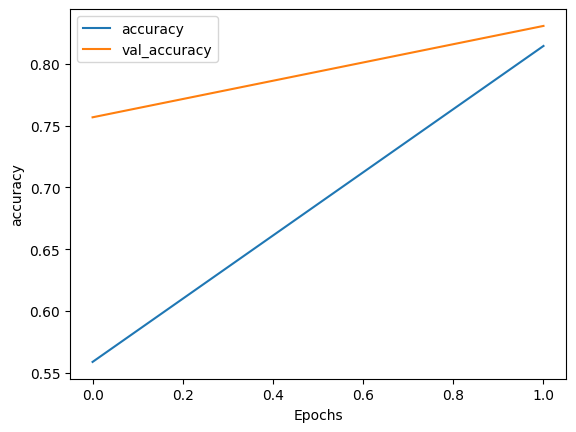

In [35]:
plot_graphs(history, "accuracy")

We achieve reazonable high validation accuracy, considering the vocabulary size and the number of epochs.

## Run a Simple Prediction

We run the model on a simple sentence. The output is a logit probability, and so we threshold in 0.0 for positive or negative review.

In [36]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 2s 2s/step


array([[0.46794352]], dtype=float32)

The prediction is that the review is positive, which seems true. Nonetheless, the probability is very near the threshold. This might indicate that the model can be improved.

## Stacking two or more LSTM


Recurrent Layers have the option to return sequences. This means that the output for each neuron is returned, and not just the last one (a 2D tensor of shape (batch_size, output_feature)).

If we return the sequences, we obtain a 3D tensor of shape (batch_size, time_steps, output_features). This can be given as input for consective RNNs, since it has 3 axes as the input.

In [37]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

The rest of the training configuration is the same.

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

We now train the model with the same configuration as before.

In [39]:
history = model.fit(train_dataset, epochs=1,
                    validation_data=test_dataset,
                    validation_steps=30)

391/391 [==============================] - 833s 2s/step - loss: 0.6265 - accuracy: 0.5770 - val_loss: 0.4957 - val_accuracy: 0.7812


We now plot the train and validation results. 

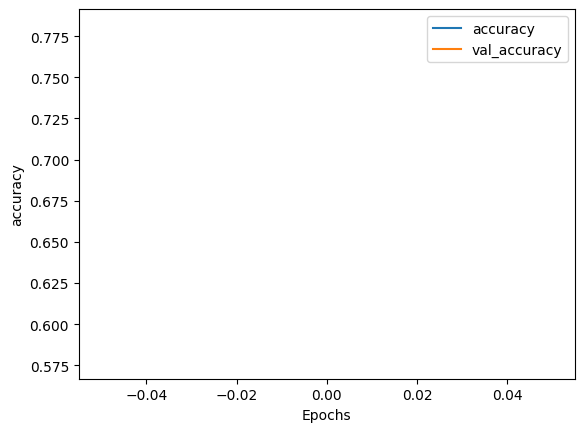

In [40]:
plot_graphs(history, "accuracy")

### Evaluation

We evaluate the model on the test set to obtain the best loss and accuracy values.

In [41]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 118s 303ms/step - loss: 0.4867 - accuracy: 0.7888
Test Loss: 0.48673340678215027
Test Accuracy: 0.7888000011444092


Finally, we make a prediction on a simple sentence:

In [42]:
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-0.5556397]]


In [43]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 0s 26ms/step


array([[0.21777005]], dtype=float32)

The model acctually did not improve much the performance. One 